In [3]:
import matplotlib.pyplot as plt
import re

# filenames = ["calm.txt", "2.txt", "3.txt", "4.txt", "5.txt"]
filenames = ["data\k05_12.txt"]
file_name = filenames[0]

<>:5: SyntaxWarning: invalid escape sequence '\k'
<>:5: SyntaxWarning: invalid escape sequence '\k'
C:\Users\phel\AppData\Local\Temp\ipykernel_6452\930758601.py:5: SyntaxWarning: invalid escape sequence '\k'
  filenames = ["data\k05_12.txt"]


In [4]:
ch1, ch2, ch3 = [], [], []

with open(file_name, "r") as file:
    for line in file:
        match = re.search(r">CH1:(\d+),CH2:(\d+),CH3:(\d+)", line)
        # match = re.search(r"EMG_RAW=(\d+), EMG_FILT=(\d+)", line)
        if match:
            ch1.append(int(match.group(1)))
            ch2.append(int(match.group(2)))
            ch3.append(int(match.group(3)))
            # ch4.append(int(match.group(4)))

time = [i / 100000 for i in range(len(ch1))]



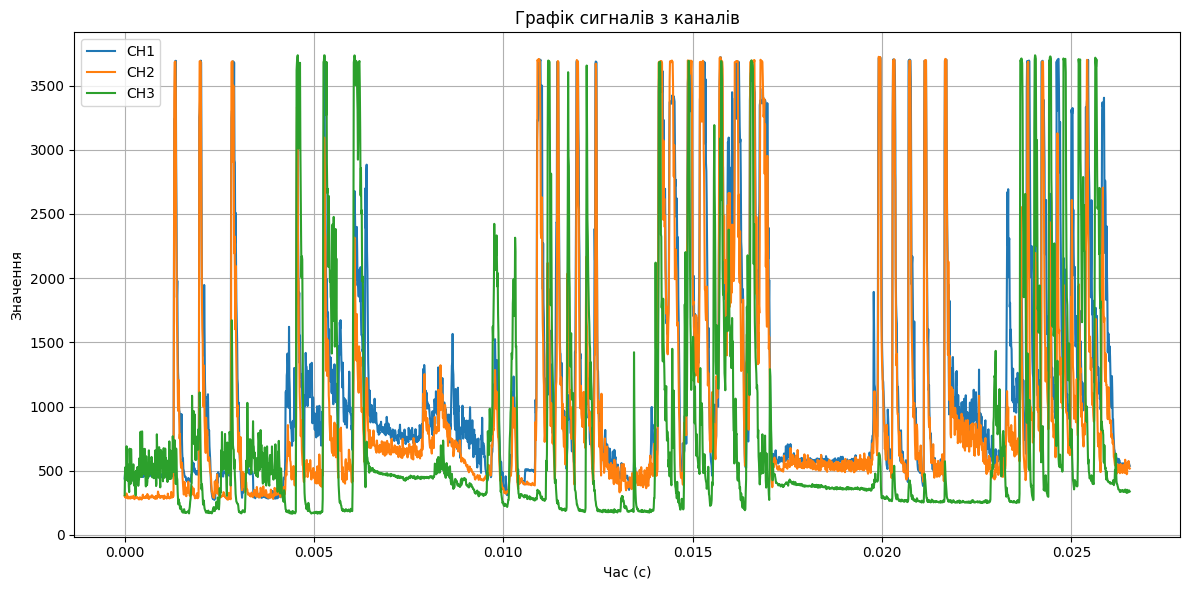

In [9]:
plt.figure(figsize=(12, 6))


plt.plot(time, ch1, label="CH1")
plt.plot(time, ch2, label="CH2")
plt.plot(time, ch3, label="CH3")
#plt.plot(time, ch4, label="CH4")


plt.title("Графік сигналів з каналів")
plt.xlabel("Час (с)")
plt.ylabel("Значення")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
import numpy as np

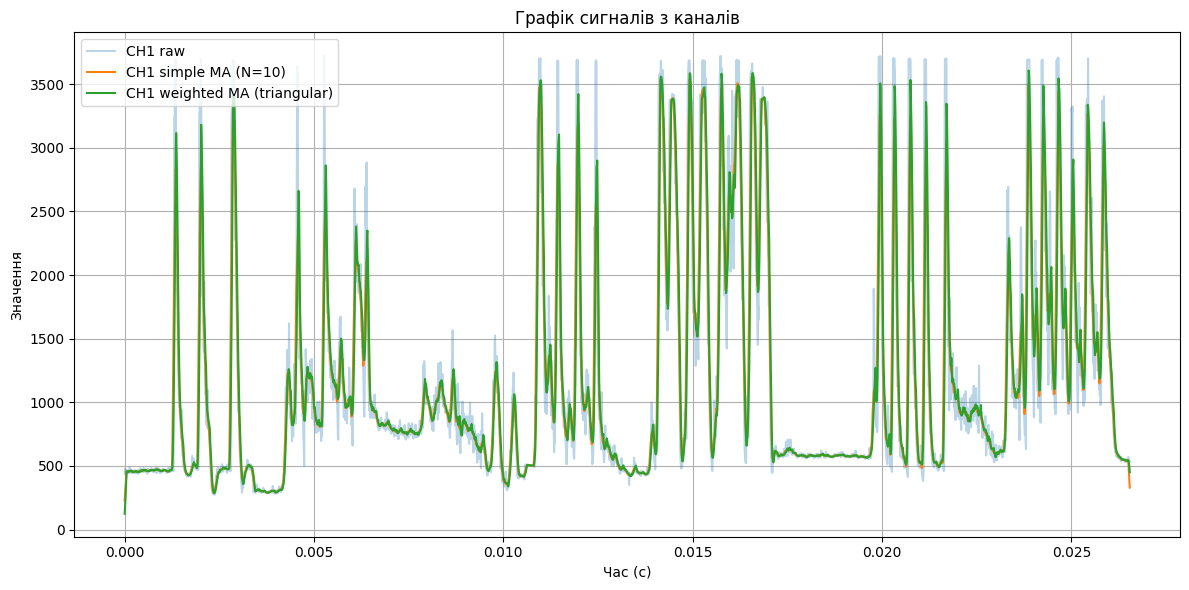

In [7]:
ch1_arr = np.array(ch1)

# ---- просте середнє ----
window_size = 10
kernel_ma = np.ones(window_size) / window_size
ch1_ma = np.convolve(ch1_arr, kernel_ma, mode="same")

# ---- зважене (трикутне) середнє ----
w = np.arange(1, window_size + 1, dtype=float)  # [1, 2, ..., 100]
kernel_w = w / w.sum()                          # нормалізація
ch1_wma = np.convolve(ch1_arr, kernel_w, mode="same")

plt.figure(figsize=(12, 6))
plt.plot(time, ch1_arr, label="CH1 raw", alpha=0.3)
plt.plot(time, ch1_ma, label=f"CH1 simple MA (N={window_size})")
plt.plot(time, ch1_wma, label=f"CH1 weighted MA (triangular)")
plt.xlabel("Час (с)")
plt.ylabel("Значення")
plt.title("Графік сигналів з каналів")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

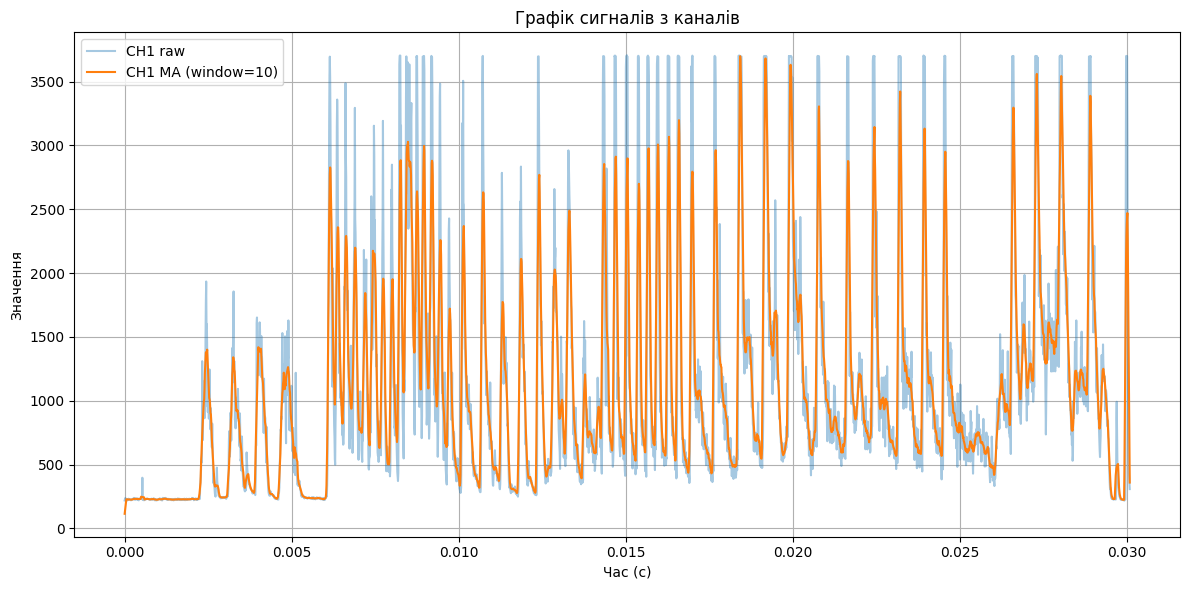

In [7]:
window_size = 10  # розмір вікна у семплах (пограйся 20 / 50 / 100)
kernel = np.ones(window_size) / window_size

ch1_arr = np.array(ch1)
ch1_ma = np.convolve(ch1_arr, kernel, mode="same")  # згладжений сигнал


plt.figure(figsize=(12, 6))

# сирий сигнал (блідіший)
plt.plot(time, ch1_arr, label="CH1 raw", alpha=0.4)

# згладжений сигнал
plt.plot(time, ch1_ma, label=f"CH1 MA (window={window_size})")

plt.title("Графік сигналів з каналів")
plt.xlabel("Час (с)")
plt.ylabel("Значення")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

EMG Filter initialized
Window=50, Threshold=500
Angle range: 0-90 degrees
Processing data through custom filter...


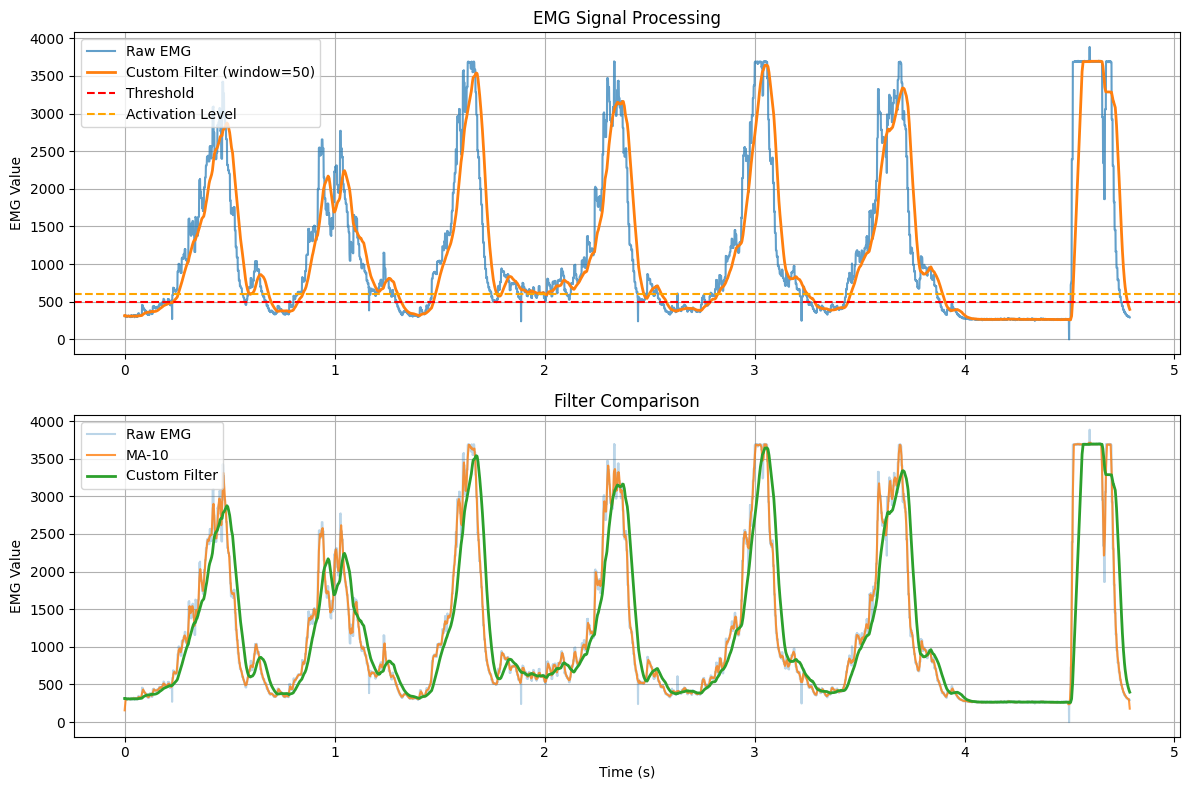


Filter Statistics:
Raw data range: 0 - 3885
Custom filtered range: 260 - 3695
Servo angle range: 0 - 79
Activation events: 2821
Final filter state: full=True, index=38


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import re
from typing import List, Tuple

class EMGFilter:
    def __init__(self, window_size: int = 50, threshold: int = 500, 
                 servo_rest_angle: int = 0, servo_active_angle: int = 90,
                 emg_update_rate: int = 10):
        self.window_size = window_size
        self.threshold = threshold
        self.servo_rest_angle = servo_rest_angle
        self.servo_active_angle = servo_active_angle
        self.emg_update_rate = emg_update_rate
        
        # Initialize filter state - use regular Python integers to avoid overflow
        self.buf = [0] * window_size  # Use list instead of np.uint16
        self.sum = 0
        self.filtered = 0
        self.index = 0
        self.full = False
        self.servo_angle = servo_rest_angle
        self.last_raw_value = 0
        self.last_filtered_value = 0
        
        # Peak detection state
        self.activated = False
        self.peak_start_time = 0
        
        print(f"EMG Filter initialized")
        print(f"Window={window_size}, Threshold={threshold}")
        print(f"Angle range: {servo_rest_angle}-{servo_active_angle} degrees")
    
    def update_filter(self, raw_value: int) -> None:
        """Update moving average filter"""
        self.last_raw_value = raw_value
        
        i = self.index
        old_value = self.buf[i]
        self.buf[i] = raw_value
        
        if self.full:
            self.sum += raw_value - old_value
        else:
            self.sum += raw_value
        
        count = self.window_size if self.full else (i + 1)
        self.filtered = self.sum // count
        self.last_filtered_value = self.filtered
        
        self.index += 1
        if self.index >= self.window_size:
            self.index = 0
            self.full = True
    
    def update_servo_from_emg(self, current_time: int) -> None:
        """Update servo position based on filtered EMG signal with hysteresis"""
        TH_ON = self.threshold + 100   # top threshold
        TH_OFF = self.threshold - 50   # bottom threshold with hysteresis
        MIN_PEAK_DURATION = 50         # ms
        
        emg_value = self.filtered
        
        # Hysteresis-based activation
        if emg_value > TH_ON:
            if self.peak_start_time == 0:
                self.peak_start_time = current_time
            
            if (current_time - self.peak_start_time) >= MIN_PEAK_DURATION:
                self.activated = True
        else:
            self.peak_start_time = 0
        
        if self.activated and emg_value < TH_OFF:
            self.activated = False
            self.peak_start_time = 0
        
        # Calculate target angle
        if not self.activated:
            target_angle = self.servo_rest_angle
        else:
            angle_range = self.servo_active_angle - self.servo_rest_angle
            signal_range = 4095 - TH_ON
            
            if signal_range > 0 and emg_value > TH_ON:
                tmp = (emg_value - TH_ON) * angle_range // signal_range
                target_angle = self.servo_rest_angle + tmp
                target_angle = min(target_angle, self.servo_active_angle)
            else:
                target_angle = self.servo_rest_angle
        
        # Smooth servo movement
        if self.servo_angle < target_angle:
            self.servo_angle += 1
        elif self.servo_angle > target_angle:
            self.servo_angle -= 1
    
    def process_sample(self, raw_value: int, current_time: int) -> dict:
        """Process a single EMG sample and return results"""
        self.update_filter(raw_value)
        self.update_servo_from_emg(current_time)
        
        # Determine status
        if self.last_filtered_value > self.threshold + 100:
            status = "ACTIVE"
        elif self.last_filtered_value > self.threshold:
            status = "THRESHOLD"
        else:
            status = "INACTIVE"
        
        return {
            'raw': self.last_raw_value,
            'filtered': self.last_filtered_value,
            'angle': self.servo_angle,
            'status': status,
            'activated': self.activated
        }

def load_emg_data(filename: str) -> Tuple[List[int], List[int]]:
    """Load EMG data from log file"""
    raw_data = []
    filtered_data = []
    
    with open(filename, "r") as file:
        for line in file:
            # match = re.search(r"EMG_RAW=(\d+), EMG_FILT=(\d+)", line)
            match = re.search(r">CH1:(\d+),CH2:(\d+),CH3:(\d+)", line)
            if match:
                raw_data.append(int(match.group(1)))
                filtered_data.append(int(match.group(2)))
    
    return raw_data, filtered_data

def plot_comparison(raw_data: List[int], filtered_data: List[int], 
                   emg_filter: EMGFilter, sample_rate: float = 1000):
    """Plot comparison between raw data, different filters, and servo output"""
    time = [i / sample_rate for i in range(len(raw_data))]
    
    # Process data through our filter
    custom_filtered = []
    servo_angles = []
    status_flags = []
    
    for i, raw_val in enumerate(raw_data):
        result = emg_filter.process_sample(raw_val, i * (1000 // sample_rate))
        custom_filtered.append(result['filtered'])
        servo_angles.append(result['angle'])
        status_flags.append(1 if result['activated'] else 0)
    
    # Create comparison plots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot 1: Raw vs Custom Filter
    ax1.plot(time, raw_data, label="Raw EMG", alpha=0.7, linewidth=1)
    ax1.plot(time, custom_filtered, label=f"Custom Filter (window={emg_filter.window_size})", linewidth=2)
    ax1.axhline(y=emg_filter.threshold, color='r', linestyle='--', label=f'Threshold ({emg_filter.threshold})')
    ax1.axhline(y=emg_filter.threshold + 100, color='orange', linestyle='--', label='Activation Threshold')
    ax1.set_title("Raw vs Custom EMG Filter")
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("EMG Value")
    ax1.legend()
    ax1.grid(True)
    
    # Plot 2: Different Filter Comparison
    window_sizes = [10, 20, 50, 100]
    ax2.plot(time, raw_data, label="Raw EMG", alpha=0.4, linewidth=1)
    
    for ws in window_sizes:
        kernel = np.ones(ws) / ws
        ma_filtered = np.convolve(raw_data, kernel, mode='same')
        ax2.plot(time, ma_filtered, label=f"MA window={ws}", alpha=0.8)
    
    ax2.plot(time, custom_filtered, label="Custom Filter", linewidth=2, color='black')
    ax2.set_title("Comparison of Different Moving Average Windows")
    ax2.set_xlabel("Time (s)")
    ax2.set_ylabel("EMG Value")
    ax2.legend()
    ax2.grid(True)
    
    # Plot 3: Servo Control Output
    ax3.plot(time, custom_filtered, label="Filtered EMG", color='blue')
    ax3_twin = ax3.twinx()
    ax3_twin.plot(time, servo_angles, label="Servo Angle", color='red', linewidth=2)
    ax3.axhline(y=emg_filter.threshold, color='g', linestyle='--', label='EMG Threshold')
    ax3.set_title("EMG Signal vs Servo Angle")
    ax3.set_xlabel("Time (s)")
    ax3.set_ylabel("EMG Value", color='blue')
    ax3_twin.set_ylabel("Servo Angle (degrees)", color='red')
    ax3.legend(loc='upper left')
    ax3_twin.legend(loc='upper right')
    ax3.grid(True)
    
    # Plot 4: Activation Detection
    ax4.plot(time, custom_filtered, label="Filtered EMG", color='blue')
    ax4.fill_between(time, 0, 1, where=status_flags, 
                    alpha=0.3, color='green', transform=ax4.get_xaxis_transform(),
                    label='Activated')
    ax4.axhline(y=emg_filter.threshold + 100, color='red', linestyle='--', label='Activation Threshold')
    ax4.axhline(y=emg_filter.threshold - 50, color='orange', linestyle='--', label='Deactivation Threshold')
    ax4.set_title("Activation Detection with Hysteresis")
    ax4.set_xlabel("Time (s)")
    ax4.set_ylabel("EMG Value")
    ax4.legend()
    ax4.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return custom_filtered, servo_angles

# Alternative: Simple plotting function for quick testing
def plot_simple_comparison(raw_data, custom_filtered, emg_filter, sample_rate=1000):
    """Simplified plotting for quick testing"""
    time = [i / sample_rate for i in range(len(raw_data))]
    
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 1, 1)
    plt.plot(time, raw_data, label='Raw EMG', alpha=0.7)
    plt.plot(time, custom_filtered, label=f'Custom Filter (window={emg_filter.window_size})', linewidth=2)
    plt.axhline(y=emg_filter.threshold, color='r', linestyle='--', label='Threshold')
    plt.axhline(y=emg_filter.threshold + 100, color='orange', linestyle='--', label='Activation Level')
    plt.title('EMG Signal Processing')
    plt.ylabel('EMG Value')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(2, 1, 2)
    # Calculate simple moving average for comparison
    window_10 = 10
    kernel_10 = np.ones(window_10) / window_10
    ma_10 = np.convolve(raw_data, kernel_10, mode='same')
    
    plt.plot(time, raw_data, label='Raw EMG', alpha=0.3)
    plt.plot(time, ma_10, label=f'MA-{window_10}', alpha=0.8)
    plt.plot(time, custom_filtered, label='Custom Filter', linewidth=2)
    plt.title('Filter Comparison')
    plt.xlabel('Time (s)')
    plt.ylabel('EMG Value')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Usage example:
if __name__ == "__main__":
    # Load your data
    filename = "data/m17_11.txt"
    raw_data, original_filtered = load_emg_data(filename)
    
    # Initialize filter with same parameters as C code
    emg_filter = EMGFilter(
        window_size=50,        # 50ms window
        threshold=500,         # Adjust based on your data
        servo_rest_angle=0,
        servo_active_angle=90,
        emg_update_rate=10
    )
    
    # Process data through our filter
    custom_filtered = []
    servo_angles = []
    
    print("Processing data through custom filter...")
    for i, raw_val in enumerate(raw_data):
        result = emg_filter.process_sample(raw_val, i * 10)  # Assuming 100Hz data
        custom_filtered.append(result['filtered'])
        servo_angles.append(result['angle'])
    
    # Plot comparison
    plot_simple_comparison(raw_data, custom_filtered, emg_filter)
    
    # Print some statistics
    print(f"\nFilter Statistics:")
    print(f"Raw data range: {min(raw_data)} - {max(raw_data)}")
    print(f"Custom filtered range: {min(custom_filtered)} - {max(custom_filtered)}")
    print(f"Servo angle range: {min(servo_angles)} - {max(servo_angles)}")
    activation_count = sum(1 for angle in servo_angles if angle > emg_filter.servo_rest_angle)
    print(f"Activation events: {activation_count}")
    print(f"Final filter state: full={emg_filter.full}, index={emg_filter.index}")

Loading data from data/m17_11.txt...
Loaded 4788 samples
EMG Filter initialized - EXACT C replica
Window=50, Threshold=500
Processing through YOUR custom filter...
EMG_DATA: RAW=314, FILTERED=314
EMG_DATA: RAW=378, FILTERED=353
EMG_DATA: RAW=470, FILTERED=465
EMG_DATA: RAW=1016, FILTERED=1021
EMG_DATA: RAW=2429, FILTERED=2040
EMG_DATA: RAW=2200, FILTERED=2749
EMG_DATA: RAW=814, FILTERED=601
EMG_DATA: RAW=378, FILTERED=482
EMG_DATA: RAW=450, FILTERED=385
EMG_DATA: RAW=1496, FILTERED=1189
EMG_DATA: RAW=2219, FILTERED=1696
EMG_DATA: RAW=1623, FILTERED=1451
EMG_DATA: RAW=616, FILTERED=664
EMG_DATA: RAW=438, FILTERED=610
EMG_DATA: RAW=302, FILTERED=317
EMG_DATA: RAW=1038, FILTERED=825
EMG_DATA: RAW=2779, FILTERED=2304
EMG_DATA: RAW=1789, FILTERED=2935
EMG_DATA: RAW=901, FILTERED=639
EMG_DATA: RAW=697, FILTERED=657
EMG_DATA: RAW=553, FILTERED=605
EMG_DATA: RAW=659, FILTERED=775
EMG_DATA: RAW=983, FILTERED=903
EMG_DATA: RAW=3464, FILTERED=2365
EMG_DATA: RAW=1521, FILTERED=2679
EMG_DATA: RAW=8

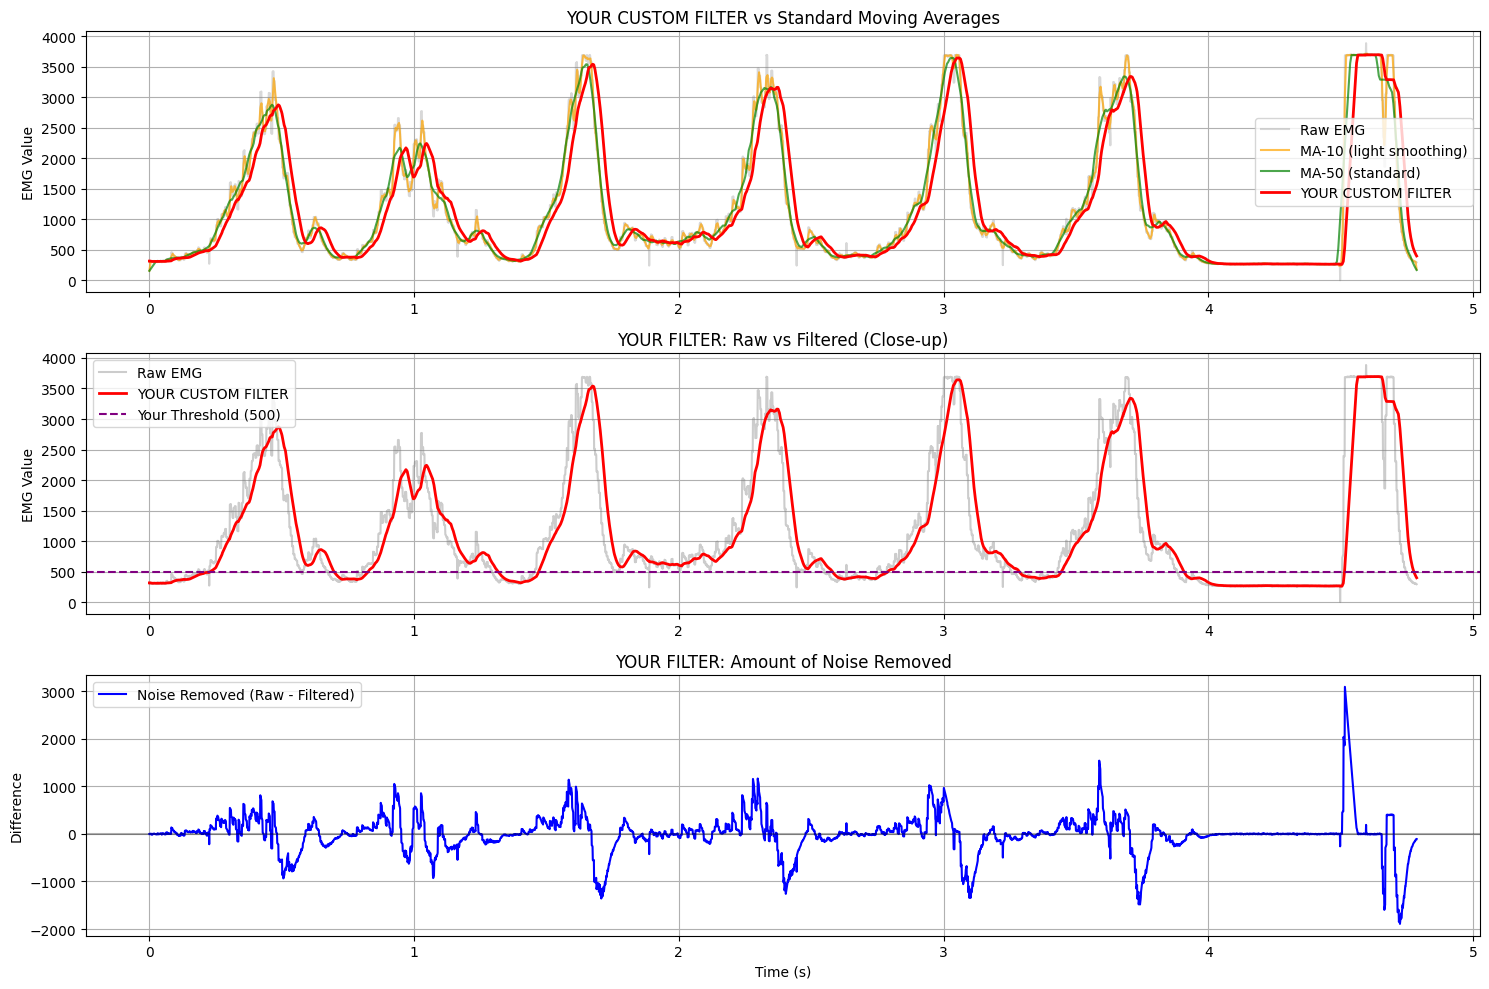


Your filter final state:
  Buffer full: True
  Current index: 38
  Current filtered value: 398


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import re
from typing import List, Tuple

class EMGFilter:
    def __init__(self, window_size: int = 50, threshold: int = 500, 
                 servo_rest_angle: int = 0, servo_active_angle: int = 90):
        self.window_size = window_size
        self.threshold = threshold
        self.servo_rest_angle = servo_rest_angle
        self.servo_active_angle = servo_active_angle
        
        # EXACT replica of your C struct
        self.buf = [0] * window_size  # uint16_t buf[EMG_WINDOW_SIZE]
        self.sum = 0                  # uint32_t sum
        self.filtered = 0             # uint16_t filtered
        self.index = 0                # uint16_t index
        self.full = False             # uint8_t full
        self.servo_angle = servo_rest_angle  # uint8_t servoAngle
        self.last_raw_value = 0       # uint16_t lastRawValue
        self.last_filtered_value = 0  # uint16_t lastFilteredValue
        
        # Peak detection state (from your C code)
        self.activated = False
        self.peak_start_time = 0
        
        print(f"EMG Filter initialized - EXACT C replica")
        print(f"Window={window_size}, Threshold={threshold}")

    def update_filter(self, raw_value: int) -> None:
        """EXACT Python version of your update_filter() C function"""
        # Your C code: static void update_filter(uint16_t rawValue)
        self.last_raw_value = raw_value
        
        i = self.index
        old_value = self.buf[i]
        self.buf[i] = raw_value
        
        if self.full:
            self.sum += raw_value - old_value  # Your exact logic
        else:
            self.sum += raw_value
        
        # Your exact counting logic
        count = self.window_size if self.full else (i + 1)
        self.filtered = self.sum // count  # Integer division like C
        self.last_filtered_value = self.filtered
        
        # Your exact circular buffer logic
        self.index += 1
        if self.index >= self.window_size:
            self.index = 0
            self.full = True

    def process_data(self, raw_data: List[int]) -> Tuple[List[int], List[int]]:
        """Process entire dataset and return filtered results"""
        filtered_results = []
        servo_angles = []
        
        for i, raw_val in enumerate(raw_data):
            self.update_filter(raw_val)
            filtered_results.append(self.filtered)
            servo_angles.append(self.servo_angle)
            
            # Print progress like your C printf
            if i % 100 == 0:
                print(f"EMG_DATA: RAW={self.last_raw_value}, FILTERED={self.last_filtered_value}")
        
        return filtered_results, servo_angles

def load_emg_data(filename: str) -> List[int]:
    """Load only RAW EMG data from your log file"""
    raw_data = []
    
    with open(filename, "r") as file:
        for line in file:
            # match = re.search(r"EMG_RAW=(\d+)", line)
            match = re.search(r">CH1:(\d+),CH2:(\d+),CH3:(\d+)", line)
            if match:
                raw_data.append(int(match.group(1)))
    
    return raw_data

def plot_your_filter_performance(raw_data: List[int], custom_filtered: List[int], 
                                emg_filter: EMGFilter, sample_rate: float = 1000):
    """Plot focusing on YOUR custom filter performance"""
    
    time = [i / sample_rate for i in range(len(raw_data))]
    
    # Calculate different MA filters for comparison
    ma_10 = np.convolve(raw_data, np.ones(10)/10, mode='same')
    ma_50 = np.convolve(raw_data, np.ones(50)/50, mode='same')  # Same window as your filter
    
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Your Filter vs Other MA Filters
    plt.subplot(3, 1, 1)
    plt.plot(time, raw_data, label='Raw EMG', alpha=0.3, color='gray')
    plt.plot(time, ma_10, label='MA-10 (light smoothing)', alpha=0.7, color='orange')
    plt.plot(time, ma_50, label='MA-50 (standard)', alpha=0.7, color='green')
    plt.plot(time, custom_filtered, label='YOUR CUSTOM FILTER', linewidth=2, color='red')
    plt.title('YOUR CUSTOM FILTER vs Standard Moving Averages')
    plt.ylabel('EMG Value')
    plt.legend()
    plt.grid(True)
    
    # Plot 2: Close-up of Your Filter Performance
    plt.subplot(3, 1, 2)
    plt.plot(time, raw_data, label='Raw EMG', alpha=0.4, color='gray')
    plt.plot(time, custom_filtered, label='YOUR CUSTOM FILTER', linewidth=2, color='red')
    plt.axhline(y=emg_filter.threshold, color='purple', linestyle='--', 
                label=f'Your Threshold ({emg_filter.threshold})')
    plt.title('YOUR FILTER: Raw vs Filtered (Close-up)')
    plt.ylabel('EMG Value')
    plt.legend()
    plt.grid(True)
    
    # Plot 3: Filter Difference (How much smoothing occurred)
    plt.subplot(3, 1, 3)
    difference = np.array(raw_data) - np.array(custom_filtered)
    plt.plot(time, difference, label='Noise Removed (Raw - Filtered)', color='blue')
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.title('YOUR FILTER: Amount of Noise Removed')
    plt.xlabel('Time (s)')
    plt.ylabel('Difference')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

def analyze_filter_performance(raw_data: List[int], custom_filtered: List[int]):
    """Analyze how well your filter works"""
    raw_array = np.array(raw_data)
    filtered_array = np.array(custom_filtered)
    
    print("\n" + "="*50)
    print("YOUR CUSTOM FILTER PERFORMANCE ANALYSIS")
    print("="*50)
    
    # Noise reduction
    noise_removed = raw_array - filtered_array
    avg_noise_reduction = np.mean(np.abs(noise_removed))
    
    print(f"Raw signal stats:")
    print(f"  Mean: {np.mean(raw_array):.1f}, Std: {np.std(raw_array):.1f}")
    print(f"  Min: {np.min(raw_array)}, Max: {np.max(raw_array)}")
    
    print(f"\nYour filtered signal stats:")
    print(f"  Mean: {np.mean(filtered_array):.1f}, Std: {np.std(filtered_array):.1f}")
    print(f"  Min: {np.min(filtered_array)}, Max: {np.max(filtered_array)}")
    
    print(f"\nFilter performance:")
    print(f"  Average noise removed: {avg_noise_reduction:.1f} units")
    print(f"  Standard deviation reduction: {np.std(raw_array) - np.std(filtered_array):.1f} units")
    print(f"  Smoothing factor: {np.std(raw_array)/np.std(filtered_array):.2f}x smoother")

# MAIN EXECUTION - SEE YOUR FILTER IN ACTION
if __name__ == "__main__":
    # Load your data
    filename = "data/m17_11.txt"
    print(f"Loading data from {filename}...")
    raw_data = load_emg_data(filename)
    print(f"Loaded {len(raw_data)} samples")
    
    # Initialize YOUR exact filter
    your_filter = EMGFilter(
        window_size=50,        # Your 50ms window
        threshold=500,         # Your threshold
        servo_rest_angle=0,
        servo_active_angle=90
    )
    
    # Process data through YOUR filter
    print("Processing through YOUR custom filter...")
    your_filtered, servo_angles = your_filter.process_data(raw_data)
    
    # Analyze performance
    analyze_filter_performance(raw_data, your_filtered)
    
    # Plot YOUR filter performance
    plot_your_filter_performance(raw_data, your_filtered, your_filter)
    
    print(f"\nYour filter final state:")
    print(f"  Buffer full: {your_filter.full}")
    print(f"  Current index: {your_filter.index}")
    print(f"  Current filtered value: {your_filter.filtered}")